Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MONAI pipeline with PyTorch 2.0 Features

This notebook introduces how to use `torch.compile` in the MONAI pipeline. `torch.compile` is the main API for PyTorch 2.0, which wraps your model and returns a compiled model. It is a fully additive (and optional) feature and hence 2.0 is 100% backward compatible by definition. We also run an end-to-end pipeline based on ["fast_training_tutorial.ipynb"](https://github.com/Project-MONAI/tutorials/blob/main/acceleration/fast_training_tutorial.ipynb), and the speed up is 1.16x.

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, matplotlib]"
# %pip install -q torch==2.1.0

## Setup imports

In [ ]:
import os
import torch
import shutil
import tempfile
import numpy as np
import matplotlib.pyplot as plt

import monai
import monai.transforms as mt
from monai.config import print_config
from monai.utils import set_determinism
from monai.bundle import download, create_workflow
from monai.engines import SupervisedTrainer

print_config()

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified, a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/Data


## Download dataset

In [3]:
sample_url = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases"
sample_url += "/download/0.8.1/totalSegmentator_mergedLabel_samples.zip"
monai.apps.download_and_extract(sample_url, output_dir=root_dir, filepath="samples.zip")

base_name = os.path.join(root_dir, "totalSegmentator_mergedLabel_samples")
input_data = []
for filename in os.listdir(os.path.join(base_name, "imagesTr")):
    input_data.append(
        {
            "image": os.path.join(base_name, "imagesTr", filename),
            "label": os.path.join(base_name, "labelsTr", filename),
        }
    )

2024-02-26 10:29:47,048 - INFO - Expected md5 is None, skip md5 check for file samples.zip.
2024-02-26 10:29:47,049 - INFO - File exists: samples.zip, skipped downloading.
2024-02-26 10:29:47,051 - INFO - Writing into directory: /workspace/Data.


## Set deterministic for reproducibility

In [4]:
set_determinism(seed=0)

## Set up timing and training functions

For best accuracies, we use CUDA events and synchronization to measure the forward and backward propagations in training.

In [5]:
def timed(fn):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    result = fn()
    end.record()
    torch.cuda.synchronize()
    return result, start.elapsed_time(end) / 1000


def train(model, inputs, labels):
    outputs = model(inputs)
    loss_function = monai.losses.DiceCELoss(to_onehot_y=True, softmax=True)
    loss = loss_function(outputs, labels)
    loss.backward()
    return loss

## Set up model

Here we used `create_workflow` to get the network instance from the bundle. You can also initialize your own network.

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
bundle_dir = "./bundle"
os.makedirs(bundle_dir, exist_ok=True)

bundle = download("wholeBody_ct_segmentation", bundle_dir=bundle_dir)
config_file = os.path.join(bundle_dir, "wholeBody_ct_segmentation/configs/train.json")
train_workflow = create_workflow(config_file=str(config_file), workflow_type="train")


def init_model(device):
    return train_workflow.network_def.to(device)

2024-02-26 10:29:57,384 - INFO - --- input summary of monai.bundle.scripts.download ---
2024-02-26 10:29:57,386 - INFO - > name: 'wholeBody_ct_segmentation'
2024-02-26 10:29:57,386 - INFO - > bundle_dir: './bundle'
2024-02-26 10:29:57,387 - INFO - > source: 'monaihosting'
2024-02-26 10:29:57,388 - INFO - > remove_prefix: 'monai_'
2024-02-26 10:29:57,389 - INFO - > progress: True
2024-02-26 10:29:57,391 - INFO - ---


2024-02-26 10:29:57,559 - INFO - Expected md5 is None, skip md5 check for file bundle/wholeBody_ct_segmentation_v0.2.2.zip.
2024-02-26 10:29:57,560 - INFO - File exists: bundle/wholeBody_ct_segmentation_v0.2.2.zip, skipped downloading.
2024-02-26 10:29:57,560 - INFO - Writing into directory: bundle.
2024-02-26 10:29:58,542 - INFO - --- input summary of monai.bundle.scripts.run ---
2024-02-26 10:29:58,543 - INFO - > config_file: './bundle/wholeBody_ct_segmentation/configs/train.json'
2024-02-26 10:29:58,544 - INFO - > workflow_type: 'train'
2024-02-26 10:29:58,544 - INFO - 

## Set up DataLoader and train transforms

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

transform = mt.Compose(
    [
        mt.LoadImageD(keys=("image", "label"), image_only=True, ensure_channel_first=True),
        mt.SpacingD(keys=("image", "label"), pixdim=1.5),
        mt.EnsureTypeD(keys=("image", "label"), device=device),
        mt.RandRotateD(
            keys=("image", "label"),
            prob=1.0,
            range_x=0.1,
            range_y=0.1,
            range_z=0.3,
            mode=("bilinear", "nearest"),
        ),
        mt.RandZoomD(keys=("image", "label"), prob=1.0, min_zoom=0.8, max_zoom=1.2, mode=("trilinear", "nearest")),
        mt.ResizeWithPadOrCropD(keys=("image", "label"), spatial_size=(96, 96, 96)),
        # add `FromMetaTensorD` to convert `MetaTensor` to `torch.Tensor`
        mt.FromMetaTensorD(keys=("image", "label")),
    ]
)

dataset = monai.data.CacheDataset(data=input_data, transform=transform, cache_rate=1.0, num_workers=4)
data_loader = monai.data.DataLoader(dataset, batch_size=1)

Loading dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


## Training in eager mode

In [8]:
# start a typical PyTorch training
epoch_num = 50
model = init_model(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

epoch_loss_values = []
eager_time = []
for epoch in range(epoch_num):
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in data_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        loss, train_time = timed(lambda: train(model, inputs, labels))  # noqa: B023
        optimizer.step()
        epoch_loss += loss.item()
        eager_time.append(train_time)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    if epoch < 5:
        print(
            f"epoch {epoch + 1}/{epoch_num} average loss: {epoch_loss:.4f}, "
            f"time: {sum(eager_time[epoch*step: epoch*step+step]):.4f}"
        )
print(f"mean training time per iteration: {np.mean(eager_time):.4f} seconds")

epoch 1/50 average loss: 5.3303, time: 4.0818
epoch 2/50 average loss: 4.8197, time: 1.6785
epoch 3/50 average loss: 4.3100, time: 1.6776
epoch 4/50 average loss: 3.7214, time: 1.6770
epoch 5/50 average loss: 3.4800, time: 1.6763
mean training time per iteration: 0.0863 seconds


## Train the model with torch.compile

The only difference is that we wrap the model with `torch.compile`. You may also see different speedup results depending on the chosen mode argument. The "reduce-overhead" mode uses CUDA graphs to further reduce the overhead of Python. For your own models, you may need to experiment with different modes to maximize speedup. You can read more about modes [here](https://pytorch.org/get-started/pytorch-2.0/#user-experience).

In [9]:
model_opt = torch.compile(init_model(device), mode="reduce-overhead")

In [10]:
# start a typical PyTorch training
optimizer = torch.optim.Adam(model_opt.parameters(), 1e-3)

epoch_loss_values = []
compile_time = []
for epoch in range(epoch_num):
    model_opt.train()
    epoch_loss = 0
    step = 0
    for batch_data in data_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        loss, train_time = timed(lambda: train(model_opt, inputs, labels))  # noqa: B023
        optimizer.step()
        epoch_loss += loss.item()
        compile_time.append(train_time)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    if epoch < 5:
        print(
            f"epoch {epoch + 1}/{epoch_num} average loss: {epoch_loss:.4f}, "
            f"time: {sum(compile_time[epoch*step: epoch*step+step]):.4f}"
        )
print(f"mean training time per iteration after compilation: {np.mean(compile_time):.4f} seconds")

Using FallbackKernel: aten.upsample_trilinear3d
Using FallbackKernel: aten.upsample_trilinear3d_backward


epoch 1/50 average loss: 2.6643, time: 25.8817
epoch 2/50 average loss: 2.7037, time: 1.0575
epoch 3/50 average loss: 2.6043, time: 1.0573
epoch 4/50 average loss: 2.5799, time: 1.0586
epoch 5/50 average loss: 2.6259, time: 1.0585
mean training time per iteration after compilation: 0.0778 seconds


## Demonstrate the speedups
As [torch](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html) mentioned, we can see that `torch.compile` takes longer in the first epoch, as it must compile the model, but in subsequent iterations, we can see a significant improvement compared to eager. 

In [11]:
print(f"first iteration: {eager_time[0]:.3f}s(eager mode) vs. {compile_time[0]:.3f}s(compile mode)")

speedup = np.mean(eager_time) / np.mean(compile_time)
print(f"eager mean: {np.mean(eager_time)}, compile mean: {np.mean(compile_time)}, speedup: {speedup}x")

first iteration: 2.488s(eager mode) vs. 23.759s(compile mode)
eager mean: 0.08626252268981932, compile mean: 0.07776330187988281, speedup: 1.1092960381628965x


### Plot total time and every epoch time

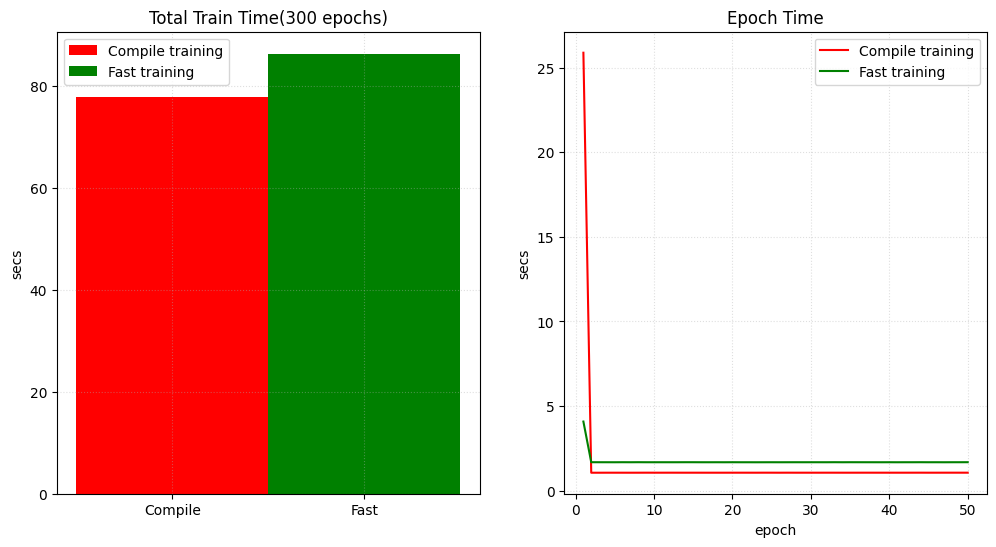

In [16]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Total Train Time(300 epochs)")
plt.bar("Compile", sum(compile_time), 1, label="Compile training", color="red")
plt.bar("Fast", sum(eager_time), 1, label="Fast training", color="green")
plt.ylabel("secs")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Epoch Time")
x = [i + 1 for i in range(int(len(compile_time) / step))]
plt.xlabel("epoch")
plt.ylabel("secs")
plt.plot(
    x,
    [sum(compile_time[i * step : (i + 1) * step]) for i in range(int(len(compile_time) / step))],
    label="Compile training",
    color="red",
)
plt.plot(
    x,
    [sum(eager_time[i * step : (i + 1) * step]) for i in range(int(len(eager_time) / step))],
    label="Fast training",
    color="green",
)
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

We also tried `torch.compile` in [fast_training_tutorial.ipynb](https://github.com/Project-MONAI/tutorials/blob/main/acceleration/fast_training_tutorial.ipynb).
The total training time for fast and compile is as follows: 354.9534s and 305.6460s, speedup: 1.16x.

## Use `torch.compile` with Engine Classes

We can simply set `compile=True` in the `SupervisedTrainer` and `SupervisedEvaluator`. Here we convert data to `torch.Tensor` internally if set `compile=True`. Here is the [ticket](https://github.com/pytorch/pytorch/issues/117026) we can track.

In [ ]:
loss_function = monai.losses.DiceCELoss(to_onehot_y=True, softmax=True)
trainer = SupervisedTrainer(
    device=device,
    max_epochs=epoch_num,
    train_data_loader=data_loader,
    network=model,
    optimizer=optimizer,
    loss_function=loss_function,
    # postprocessing=post_transform,
    # amp=args.amp,
    # key_train_metric={
    #     "train_dice": MeanDice(
    #         include_background=False,
    #         output_transform=from_engine(["pred", "label"]),
    #     )
    # },
    compile=True,
    # you can also add `compile_kwargs` dict of the args for `torch.compile()` API
    compile_kwargs={},
)

## Cleanup data directory
Remove directory if a temporary was used.

In [14]:
if directory is None:
    shutil.rmtree(root_dir)